In [1]:
# Import bibliotecas
import os
import pandas as pd
from datetime import timedelta

In [2]:
# Função leitura dos dados
def read_wind_data(dir_name='Datathons_pem_vento'):
    """
    Função que faz leitura de todos os arquivos de dados de ventos e retorna um dataframe contendo todos os dados.
    Presume-se que os dados de vento são em intervalos de meia hora.
    A pasta precisa ter apenas arquivos de vento, formato txt.
    
    Args:
        dir_name (str, optional): string com o nome do diretório onde os dados estão
        
    Returns:
        df: pandas dataframe contendo as informações dos arquivos lidos.
            Cada coluna é uma usina e os index das linha são timestamps, ordenados.
    """
    path = os.path.join(os.getcwd(), dir_name)
    df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('txt'):
                df_temp = pd.read_csv(file_path, header=None, sep=';')
                df_temp[0] = pd.to_datetime(df_temp[0], format='%Y%m%d')
                df_temp.set_index(0, drop=True, inplace=True)
                init_date = df_temp.index[0]
                last_date = df_temp.index[-1] + timedelta(days=1) - timedelta(minutes=30)
                df_temp = df_temp.stack(dropna=False)
                df_temp.index = pd.date_range(init_date, last_date, freq='30T')
                df = pd.concat([df, pd.DataFrame(df_temp, columns=[file])])
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [3]:
df = read_wind_data()
df

,U10_Ven_Prev.txt,U10_Ven_Verif.txt,U11_Ven_Prev.txt,U11_Ven_Verif.txt,U12_Ven_Prev.txt,U12_Ven_Verif.txt,U13_Ven_Prev.txt,U13_Ven_Verif.txt,U14_Ven_Prev.txt,U14_Ven_Verif.txt,...,U5_Ven_Prev.txt,U5_Ven_Verif.txt,U6_Ven_Prev.txt,U6_Ven_Verif.txt,U7_Ven_Prev.txt,U7_Ven_Verif.txt,U8_Ven_Prev.txt,U8_Ven_Verif.txt,U9_Ven_Prev.txt,U9_Ven_Verif.txt
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.7038,NaN,NaN,NaN,NaN
2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.7238,NaN,NaN,NaN,NaN
2020-12-31 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0499,NaN,NaN,NaN,NaN
2020-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.1400,NaN,NaN,NaN,NaN


<AxesSubplot:>

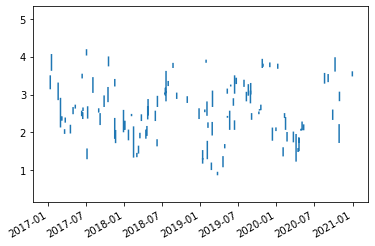

In [5]:
df.iloc[:,1].plot()